# Modelo de propensión a compra

## Configuración Inicial y Librerías

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Para el preprocesamiento y construcción de features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Para el modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# Para el manejo de desequilibrio de clases
from imblearn.under_sampling import RandomUnderSampler

# Para la evaluación del modelo
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Para la carga de datos
from os import path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Obtención de datos

In [2]:
base_path = '/content/drive/MyDrive/data/TFM/'

df_sales = pd.read_csv(path.join(base_path, 'clean_datasets/sales_clean.csv'), index_col=0)
print(f'df_sales: {df_sales.shape[0]} filas cargadas')

df_customer_commercial_activity = pd.read_csv(path.join(base_path, 'clean_datasets/customer_commercial_activity_clean.csv'), index_col=0)
print(f'df_customer_commercial_activity: {df_customer_commercial_activity.shape[0]} filas cargadas')

df_customer_products = pd.read_csv(path.join(base_path, 'clean_datasets/customer_products_clean.csv'), index_col=0)
print(f'df_customer_products: {df_customer_products.shape[0]} filas cargadas')

df_customer_sociodemographics = pd.read_csv(path.join(base_path, 'clean_datasets/customer_sociodemographics_clean.csv'), index_col=0)
print(f'df_customer_sociodemographics: {df_customer_sociodemographics.shape[0]} filas cargadas')

df_product_description = pd.read_csv(path.join(base_path, 'clean_datasets/product_description_clean.csv'), index_col=0)
print(f'product_description: {df_product_description.shape[0]} filas cargadas')

df_sales: 240773 filas cargadas
df_customer_commercial_activity: 5962924 filas cargadas
df_customer_products: 5962924 filas cargadas
df_customer_sociodemographics: 5959602 filas cargadas
product_description: 13 filas cargadas


In [3]:
# Convertir columnas de fecha a formato datetime
df_sales['month_sale'] = pd.to_datetime(df_sales['month_sale'])
df_customer_commercial_activity['entry_date'] = pd.to_datetime(df_customer_commercial_activity['entry_date'])
df_customer_products['pk_partition'] = pd.to_datetime(df_customer_products['pk_partition'])
df_customer_commercial_activity['pk_partition'] = pd.to_datetime(df_customer_commercial_activity['pk_partition'])
df_customer_sociodemographics['pk_partition'] = pd.to_datetime(df_customer_sociodemographics['pk_partition'])

In [4]:
df_product_description

,pk_product_ID,product_desc,family_product
0,4657,em_acount,account
1,3819,debit_card,payment_card
2,1364,pension_plan,pension_plan
3,2234,payroll,account
4,2235,payroll_account,account
5,8871,emc_account,account
6,2312,credit_card,payment_card
7,2335,short_term_deposit,investment
8,2336,long_term_deposit,investment
9,2673,securities,investment


## 2. Preprocesamiento y Fusión de Tablas

¿Qué atributos incluiremos para saber qué clientes comprarán ciertos productos?

Para predecir si un cliente comprará un producto, necesitamos información sobre **quién es** (demografía) y **como se comporta** (fidelización/monetario).


### 2.1. Lo primero será dividir el dataset en los 3 productos en los que nos vamos a enfocar (los 3 con los que se gana más dinero)

In [5]:
df_sales.shape

(240773, 5)

In [6]:
# Calculate the last purchase date for each customer
last_purchase_date = df_sales.groupby('cid')['month_sale'].max().reset_index()
last_purchase_date.rename(columns={'month_sale': 'last_sale_month'}, inplace=True)

# Merge the last purchase date back to the original df_sales DataFrame
df_sales = df_sales.merge(last_purchase_date, on='cid', how='left')

# Calculate the number of months since the last purchase
# We will use the maximum month in the entire dataset as the reference for "today"
latest_month_in_data = df_sales['month_sale'].max()

df_sales['recencia'] = ((latest_month_in_data - df_sales['last_sale_month']).dt.days / 30.44).round().astype(int)

df_sales.drop(columns=['last_sale_month'], inplace=True)

df_sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin,recencia
0,6666,33620,2018-05-01,2335,952.9,12
1,6667,35063,2018-06-01,2335,1625.2,11
2,6668,37299,2018-02-01,2335,1279.7,12
3,6669,39997,2018-02-01,2335,1511.9,13
4,6670,44012,2018-02-01,2335,1680.3,15


In [7]:
# Nos quedamos solo con los valores de los productos que nos interesan, es decir, los que generan más dinero según el dashboard del powerbi
df_sales['product_ID'] = df_sales['product_ID'].apply(lambda x: x if x in [1364, 2335, 2336] else 9999)

df_sales

,pk_sale,cid,month_sale,product_ID,net_margin,recencia
0,6666,33620,2018-05-01,2335,952.9,12
1,6667,35063,2018-06-01,2335,1625.2,11
2,6668,37299,2018-02-01,2335,1279.7,12
3,6669,39997,2018-02-01,2335,1511.9,13
4,6670,44012,2018-02-01,2335,1680.3,15
...,...,...,...,...,...,...
240768,247434,1553456,2019-05-01,9999,56.7,0
240769,247435,1553541,2019-05-01,9999,66.5,0
240770,247436,1553559,2019-05-01,9999,73.0,0
240771,247437,1553565,2019-05-01,9999,82.3,0


In [8]:
# pension_plan, em_acount, short_term_deposit
# sales = df_sales[df_sales['product_ID'].isin([1364, 2336, 2335])]
sales_ohe = (
    pd.get_dummies(df_sales, columns=['product_ID'])
    .rename(columns={
        'product_ID_1364':'pension_plan_purchase',
        'product_ID_2335':'short_term_deposit_purchase',
        'product_ID_2336':'long_term_deposit_purchase',
        'product_ID_9999':'others_purchase'
    })

)

print(sales_ohe.shape, '\n')
sales_ohe

(240773, 9) 



,pk_sale,cid,month_sale,net_margin,recencia,pension_plan_purchase,short_term_deposit_purchase,long_term_deposit_purchase,others_purchase
0,6666,33620,2018-05-01,952.9,12,False,True,False,False
1,6667,35063,2018-06-01,1625.2,11,False,True,False,False
2,6668,37299,2018-02-01,1279.7,12,False,True,False,False
3,6669,39997,2018-02-01,1511.9,13,False,True,False,False
4,6670,44012,2018-02-01,1680.3,15,False,True,False,False
...,...,...,...,...,...,...,...,...,...
240768,247434,1553456,2019-05-01,56.7,0,False,False,False,True
240769,247435,1553541,2019-05-01,66.5,0,False,False,False,True
240770,247436,1553559,2019-05-01,73.0,0,False,False,False,True
240771,247437,1553565,2019-05-01,82.3,0,False,False,False,True


### 2.2. Atributos de **fidelizacion** (df_customer_commercial_activity)

In [9]:
df_customer_commercial_activity.head(3)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,new_customer
0,1375586,2018-01-01,2018-01-01,KHL,1.0,02 - PARTICULARES,0
1,1050611,2018-01-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,0
2,1050612,2018-01-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,0


In [10]:
df_join1 = (
    df_customer_commercial_activity
    .merge(
        sales_ohe[['cid','month_sale', 'pension_plan_purchase', 'long_term_deposit_purchase', 'short_term_deposit_purchase', 'recencia']],
        how='right',
        left_on=['pk_cid', 'pk_partition'],
        right_on=['cid', 'month_sale']
    )
    .drop(columns=['cid','month_sale', 'entry_date'])
)

print(df_join1.shape, '\n')

df_join1.head(3)

(240773, 10) 



,pk_cid,pk_partition,entry_channel,active_customer,segment,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia
0,33620,2018-05-01,KHK,1.0,02 - PARTICULARES,0,False,False,True,12
1,35063,2018-06-01,KHN,1.0,01 - TOP,0,False,False,True,11
2,37299,2018-02-01,KHK,1.0,01 - TOP,0,False,False,True,12


### 2.3. Atributos **monetarios** (df_customer_products)


In [11]:
df_customer_products.head(3)

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
customer_products = df_customer_products.sort_values(by=['pk_cid','pk_partition']).reset_index(drop=True).copy()

products = ['short_term_deposit','loans','mortgage','funds','securities','long_term_deposit','em_account_pp','credit_card','payroll','pension_plan','payroll_account','emc_account','debit_card','em_account_p','em_acount']
for product in products:
    customer_products[f'{product}_lag1'] = customer_products.groupby('pk_cid')[product].shift(1).fillna(0)

customer_products.drop(columns=products, inplace=True)

customer_products.head(3)

,pk_cid,pk_partition,short_term_deposit_lag1,loans_lag1,mortgage_lag1,funds_lag1,securities_lag1,long_term_deposit_lag1,em_account_pp_lag1,credit_card_lag1,payroll_lag1,pension_plan_lag1,payroll_account_lag1,emc_account_lag1,debit_card_lag1,em_account_p_lag1,em_acount_lag1
0,15891,2018-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15891,2018-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,16063,2018-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Incluimos esta tabla para indicar que items tenia el cliente antes de la compra

df_join2 = df_join1.merge(customer_products, how='left', on=['pk_cid', 'pk_partition'])

print(df_join2.shape, '\n')

df_join2.head(3)

(240773, 25) 



,pk_cid,pk_partition,entry_channel,active_customer,segment,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,...,long_term_deposit_lag1,em_account_pp_lag1,credit_card_lag1,payroll_lag1,pension_plan_lag1,payroll_account_lag1,emc_account_lag1,debit_card_lag1,em_account_p_lag1,em_acount_lag1
0,33620,2018-05-01,KHK,1.0,02 - PARTICULARES,0,False,False,True,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35063,2018-06-01,KHN,1.0,01 - TOP,0,False,False,True,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37299,2018-02-01,KHK,1.0,01 - TOP,0,False,False,True,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2.4. Atributos **demográficos** (df_customer_sociodemográficos)

In [14]:
aggregated_sociodemographics = df_customer_sociodemographics.copy()
aggregated_sociodemographics['months_in_company'] = (
    aggregated_sociodemographics
    .sort_values(by=['pk_cid', 'pk_partition'])
    .groupby('pk_cid').cumcount() + 1
)
aggregated_sociodemographics['salary'] = aggregated_sociodemographics['salary'].round(2)
aggregated_sociodemographics['region_code'] = aggregated_sociodemographics['region_code'].astype(int)
aggregated_sociodemographics['age'] = aggregated_sociodemographics['age'].astype(int)

In [15]:
df_join3 = df_join2.merge(aggregated_sociodemographics, how='left', on=['pk_cid', 'pk_partition']).drop(columns=['pk_partition'])

print(df_join3.shape, '\n')

df_join3.head(3)

(240773, 29) 



,pk_cid,entry_channel,active_customer,segment,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,...,payroll_account_lag1,emc_account_lag1,debit_card_lag1,em_account_p_lag1,em_acount_lag1,region_code,gender,age,salary,months_in_company
0,33620,KHK,1.0,02 - PARTICULARES,0,False,False,True,12,0.0,...,0.0,0.0,0.0,0.0,1.0,28.0,H,50.0,138618.57,2.0
1,35063,KHN,1.0,01 - TOP,0,False,False,True,11,0.0,...,0.0,0.0,0.0,0.0,1.0,28.0,H,62.0,125530.41,2.0
2,37299,KHK,1.0,01 - TOP,0,False,False,True,12,0.0,...,0.0,0.0,0.0,0.0,1.0,30.0,V,54.0,75932.59,2.0


In [16]:
df_join3.columns

Index(['pk_cid', 'entry_channel', 'active_customer', 'segment', 'new_customer',
       'pension_plan_purchase', 'long_term_deposit_purchase',
       'short_term_deposit_purchase', 'recencia', 'short_term_deposit_lag1',
       'loans_lag1', 'mortgage_lag1', 'funds_lag1', 'securities_lag1',
       'long_term_deposit_lag1', 'em_account_pp_lag1', 'credit_card_lag1',
       'payroll_lag1', 'pension_plan_lag1', 'payroll_account_lag1',
       'emc_account_lag1', 'debit_card_lag1', 'em_account_p_lag1',
       'em_acount_lag1', 'region_code', 'gender', 'age', 'salary',
       'months_in_company'],
      dtype='object')

## 3. Preparación Final de Datos para el Modelo

### 3.1. Tratamos outliers

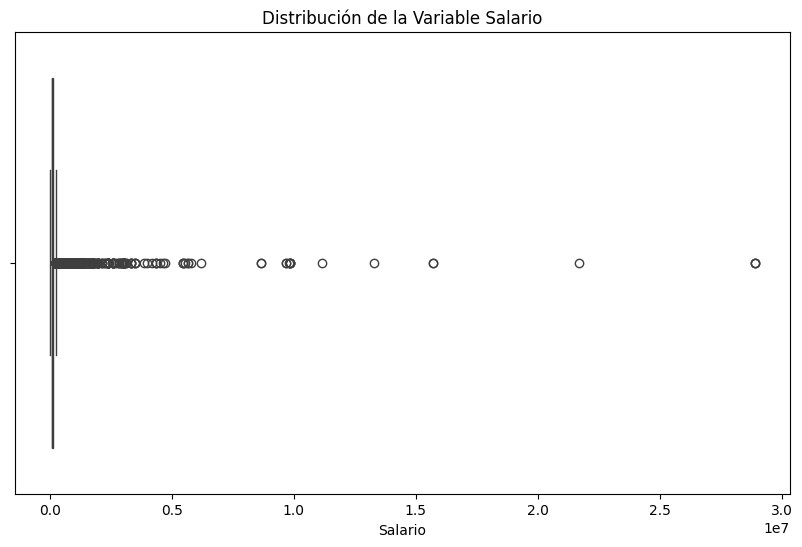

In [17]:
# Vemos que hay bastantes outliers en el salario
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_join3['salary'])
plt.title('Distribución de la Variable Salario')
plt.xlabel('Salario')
plt.show()

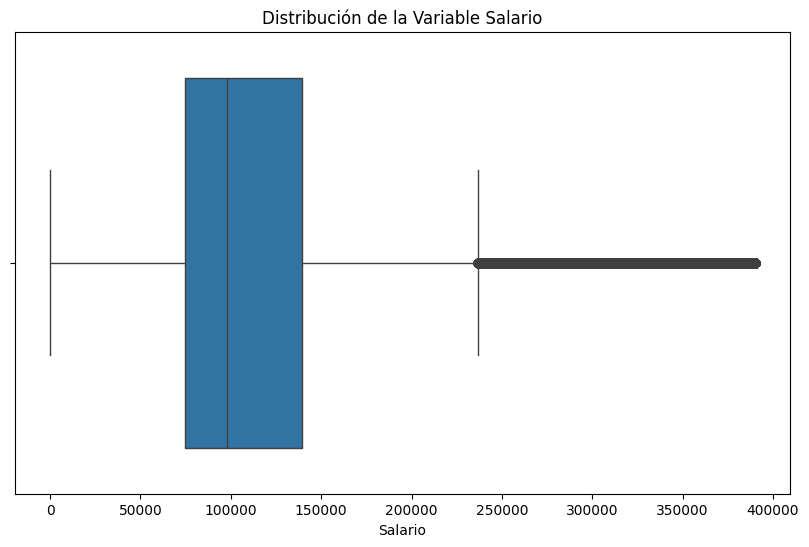

In [18]:
# Tratamos los outliers en salary quitando el percentil 99
limite_outlier = df_join3['salary'].quantile(0.99)
df_join3['salary'] = np.where(df_join3['salary'] > limite_outlier, limite_outlier, df_join3['salary'])

# Y volvemos a plotear
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_join3['salary'])
plt.title('Distribución de la Variable Salario')
plt.xlabel('Salario')
plt.show()

### 3.2. Escalamos los datos numericos

In [19]:
df_scaled = df_join3.copy()

scaler = StandardScaler()
numeric_columns = ['months_in_company', 'age', 'salary', 'recencia']
df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])

df_scaled.head(3)

,pk_cid,entry_channel,active_customer,segment,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,...,payroll_account_lag1,emc_account_lag1,debit_card_lag1,em_account_p_lag1,em_acount_lag1,region_code,gender,age,salary,months_in_company
0,33620,KHK,1.0,02 - PARTICULARES,0,False,False,True,1.302433,0.0,...,0.0,0.0,0.0,0.0,1.0,28.0,H,1.192642,0.462365,-0.458372
1,35063,KHN,1.0,01 - TOP,0,False,False,True,1.055356,0.0,...,0.0,0.0,0.0,0.0,1.0,28.0,H,2.084779,0.239476,-0.458372
2,37299,KHK,1.0,01 - TOP,0,False,False,True,1.302433,0.0,...,0.0,0.0,0.0,0.0,1.0,30.0,V,1.490021,-0.605163,-0.458372


### 3.3. Tratamos variables categóricas como el género y el region_code

In [20]:
# ENTRY_CHANNEL: agrupamos valores con menos de 1000 registros como 'otros'
print(f'Valores unicos antes: {df_scaled.entry_channel.nunique()}')

value_counts = df_scaled['entry_channel'].value_counts()
low_frequency_channels = value_counts[value_counts < 10000].index
df_scaled['entry_channel'] = df_scaled['entry_channel'].replace(low_frequency_channels, 'OTHERS')

print(f'Valores unicos despues: {df_scaled.entry_channel.nunique()}')

df_scaled['entry_channel'].value_counts()

Valores unicos antes: 45
Valores unicos despues: 8


,count
entry_channel,
KHE,101157
KHM,28696
KFC,28026
KHK,21662
KHN,19054
OTHERS,17289
KAT,14415
KHQ,10474


In [21]:
# 0 para el caso de H (Hembra), 1 para el caso de V (Varon)
df_scaled['gender'] = df_scaled['gender'].apply(lambda x: 0 if x == 'H' else 1)

In [22]:
# Para no meter 52 columnas nuevas en region code, los dividiremos entre provincias costeras y no costeras
region_codes_costa = [
    # Galicia (Atlántico / Cantábrico)
    '15', # A Coruña
    '27', # Lugo
    '36', # Pontevedra

    # Asturias y Cantabria (Cantábrico)
    '33', # Asturias
    '39', # Cantabria

    # País Vasco (Cantábrico)
    '48', # Vizcaya (Bizkaia)
    '20', # Guipúzcoa (Gipuzkoa)

    # Cataluña (Mediterráneo)
    '08', # Barcelona
    '17', # Gerona (Girona)
    '43', # Tarragona

    # Comunidad Valenciana (Mediterráneo)
    '03', # Alicante (Alacant)
    '12', # Castellón (Castelló)
    '46', # Valencia (València)

    # Región de Murcia (Mediterráneo)
    '30', # Murcia

    # Andalucía (Mediterráneo / Atlántico)
    '04', # Almería
    '11', # Cádiz
    '18', # Granada
    '21', # Huelva
    '29', # Málaga

    # Islas (Mediterráneo / Atlántico)
    '07', # Islas Baleares (Illes Balears)
    '35', # Las Palmas
    '38', # Santa Cruz de Tenerife

    # Ciudades Autónomas
    '51', # Ceuta (Aunque no es una provincia, se le asigna un código)
    '52'  # Melilla (Aunque no es una provincia, se le asigna un código)
]

df_scaled['region_code_costa'] = df_scaled['region_code'].apply(lambda x: 1 if x in region_codes_costa else 0)
df_scaled.head(3)

,pk_cid,entry_channel,active_customer,segment,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,...,emc_account_lag1,debit_card_lag1,em_account_p_lag1,em_acount_lag1,region_code,gender,age,salary,months_in_company,region_code_costa
0,33620,KHK,1.0,02 - PARTICULARES,0,False,False,True,1.302433,0.0,...,0.0,0.0,0.0,1.0,28.0,0,1.192642,0.462365,-0.458372,0
1,35063,KHN,1.0,01 - TOP,0,False,False,True,1.055356,0.0,...,0.0,0.0,0.0,1.0,28.0,0,2.084779,0.239476,-0.458372,0
2,37299,KHK,1.0,01 - TOP,0,False,False,True,1.302433,0.0,...,0.0,0.0,0.0,1.0,30.0,1,1.490021,-0.605163,-0.458372,0


In [23]:
df_final = pd.get_dummies(df_scaled, columns=['entry_channel', 'segment'], drop_first=True)

print(df_final.shape, '\n')

df_final.head(3)

(240773, 37) 



,pk_cid,active_customer,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,loans_lag1,mortgage_lag1,...,region_code_costa,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
0,33620,1.0,0,False,False,True,1.302433,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,True,False
1,35063,1.0,0,False,False,True,1.055356,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
2,37299,1.0,0,False,False,True,1.302433,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,False,False


In [24]:
df_final.to_csv(path.join(base_path, 'clean_datasets/df_final_tarea2.csv'))

## 4. Definición de la Variable Objetivo (Y)

Los productos que vamos a incluir en el modelo de propensión a compra serán los 3 con los que se gana más dinero, visto desde el dashboard de PowerBI estos productos son los siguiente:
* pension_plan
* short_term_deposit
* long_term_deposit

In [25]:
TARGET_PRODUCT_PP = 'pension_plan_purchase'
X_pension_plan = df_final.drop(columns=[TARGET_PRODUCT_PP])
y_pension_plan = df_final[TARGET_PRODUCT_PP]
print(f'Target del modelo pension_plan: {TARGET_PRODUCT_PP}')
print(f'Features del modelo pension_plan: {list(X_pension_plan.columns)}')

TARGET_PRODUCT_STD = 'short_term_deposit_purchase'
X_short_term_deposit = df_final.drop(columns=[TARGET_PRODUCT_STD])
y_short_term_deposit = df_final[TARGET_PRODUCT_STD]
print(f'Target del modelo short_term_deposit: {TARGET_PRODUCT_STD}')
print(f'Features del modelo short_term_deposit: {list(X_short_term_deposit.columns)}')

TARGET_PRODUCT_LTD = 'long_term_deposit_purchase'
X_long_term_deposit = df_final.drop(columns=[TARGET_PRODUCT_LTD])
y_long_term_deposit = df_final[TARGET_PRODUCT_LTD]
print(f'Target del modelo long_term_deposit: {TARGET_PRODUCT_LTD}')
print(f'Features del modelo long_term_deposit: {list(X_long_term_deposit.columns)}')

Target del modelo pension_plan: pension_plan_purchase
Features del modelo pension_plan: ['pk_cid', 'active_customer', 'new_customer', 'long_term_deposit_purchase', 'short_term_deposit_purchase', 'recencia', 'short_term_deposit_lag1', 'loans_lag1', 'mortgage_lag1', 'funds_lag1', 'securities_lag1', 'long_term_deposit_lag1', 'em_account_pp_lag1', 'credit_card_lag1', 'payroll_lag1', 'pension_plan_lag1', 'payroll_account_lag1', 'emc_account_lag1', 'debit_card_lag1', 'em_account_p_lag1', 'em_acount_lag1', 'region_code', 'gender', 'age', 'salary', 'months_in_company', 'region_code_costa', 'entry_channel_KFC', 'entry_channel_KHE', 'entry_channel_KHK', 'entry_channel_KHM', 'entry_channel_KHN', 'entry_channel_KHQ', 'entry_channel_OTHERS', 'segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO']
Target del modelo short_term_deposit: short_term_deposit_purchase
Features del modelo short_term_deposit: ['pk_cid', 'active_customer', 'new_customer', 'pension_plan_purchase', 'long_term_deposit_purcha

## 5. Creación y entrenamiento del modelo

### 5.1. Creación del modelo para el producto **pension_plan**



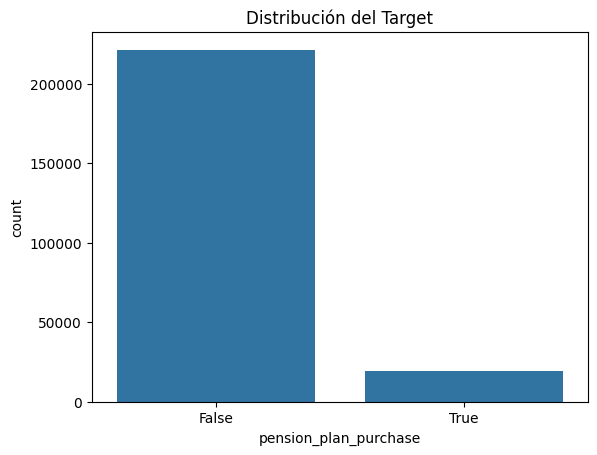

In [26]:
sns.countplot(x=df_final[TARGET_PRODUCT_PP])
plt.title('Distribución del Target')
plt.show()

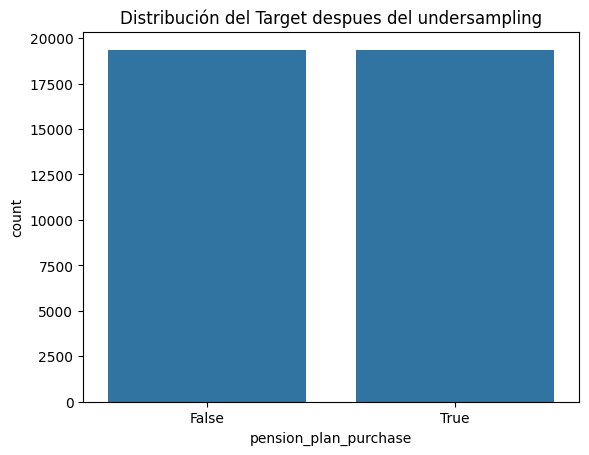

In [27]:
# Está bastante desbalanceado (solo un 8% de la población compra) por lo que aplicaremos undersampling
undersampler = RandomUnderSampler(random_state=121)
X_resampled, y_resampled = undersampler.fit_resample(X_pension_plan, y_pension_plan)

sns.countplot(x=y_resampled)
plt.title('Distribución del Target despues del undersampling')
plt.show()

In [28]:
X_train_pension_plan, X_test_pension_plan, y_train_pension_plan, y_test_pension_plan = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)

print(f'X_train: {X_train_pension_plan.shape}')
print(f'y_train: {y_train_pension_plan.shape}')
print(f'X_test: {X_test_pension_plan.shape}')
print(f'y_test: {y_test_pension_plan.shape}')

X_train: (30990, 36)
y_train: (30990,)
X_test: (7748, 36)
y_test: (7748,)


In [29]:
from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=XGBClassifier(random_state=123),
#                            param_grid=param_grid,
#                            scoring='roc_auc',  # Use AUC-ROC for evaluation
#                            cv=3,  # 3-fold cross-validation
#                            verbose=2,
#                            n_jobs=-1) # Use all available cores

# # Fit the grid search to the data
# grid_search.fit(X_train_pension_plan, y_train_pension_plan)

# # Print the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best AUC-ROC score found: ", grid_search.best_score_)

# # Get the best model
# best_model_pension_plan = grid_search.best_estimator_

In [30]:
# Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
# Definir el modelo XGBoost
model_pension_plan = XGBClassifier(
    n_estimators=300,
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    random_state=123
)
model_pension_plan.fit(X_train_pension_plan, y_train_pension_plan)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [31]:
# Guardamos el modelo para poder usarlo desde otro notebook

joblib.dump(model_pension_plan, path.join(base_path, 'models/model_pension_plan.pkl'))

['/content/drive/MyDrive/data/TFM/models/model_pension_plan.pkl']

### 5.2. Creación del modelo para el producto **short_term_deposit**

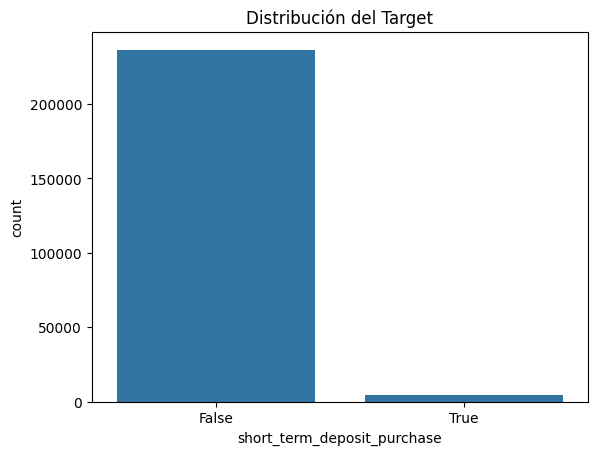

In [32]:
sns.countplot(x=df_final[TARGET_PRODUCT_STD])
plt.title('Distribución del Target')
plt.show()

In [33]:
df_final[TARGET_PRODUCT_STD].value_counts()

,count
short_term_deposit_purchase,
False,236332
True,4441


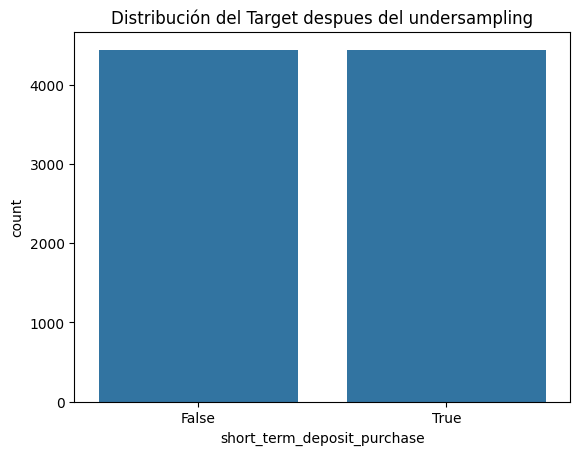

In [34]:
# Está bastante desbalanceado solo el 1,8% son compradores por lo que aplicaremos undersampling

undersampler = RandomUnderSampler(random_state=121)
X_resampled, y_resampled = undersampler.fit_resample(X_short_term_deposit, y_short_term_deposit)

sns.countplot(x=y_resampled)
plt.title('Distribución del Target despues del undersampling')
plt.show()

In [35]:
X_train_short_term_deposit, X_test_short_term_deposit, y_train_short_term_deposit, y_test_short_term_deposit = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)

print(f'X_train_short_term_deposit: {X_train_short_term_deposit.shape}')
print(f'y_train_short_term_deposit: {y_train_short_term_deposit.shape}')
print(f'X_test_short_term_deposit: {X_test_short_term_deposit.shape}')
print(f'y_test_short_term_deposit: {y_test_short_term_deposit.shape}')

X_train_short_term_deposit: (7105, 36)
y_train_short_term_deposit: (7105,)
X_test_short_term_deposit: (1777, 36)
y_test_short_term_deposit: (1777,)


In [36]:
# # from sklearn.model_selection import GridSearchCV

# # # Define the parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=XGBClassifier(random_state=123),
#                            param_grid=param_grid,
#                            scoring='roc_auc',  # Use AUC-ROC for evaluation
#                            cv=3,  # 3-fold cross-validation
#                            verbose=2,
#                            n_jobs=-1) # Use all available cores

# # Fit the grid search to the data
# grid_search.fit(X_train_short_term_deposit, y_train_short_term_deposit)

# # Print the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best AUC-ROC score found: ", grid_search.best_score_)

# # Get the best model
# best_model_short_term_deposit = grid_search.best_estimator_

In [37]:
# Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
# Definir el modelo XGBoost
model_short_term_deposit = XGBClassifier(
    n_estimators=300,
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    random_state=123
)
model_short_term_deposit.fit(X_train_short_term_deposit, y_train_short_term_deposit)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
# Guardamos el modelo para poder usarlo desde otro notebook

joblib.dump(model_short_term_deposit, path.join(base_path, 'models/model_short_term_deposit.pkl'))

['/content/drive/MyDrive/data/TFM/models/model_short_term_deposit.pkl']

### 5.3. Creación del modelo para el producto **long_term_deposit**

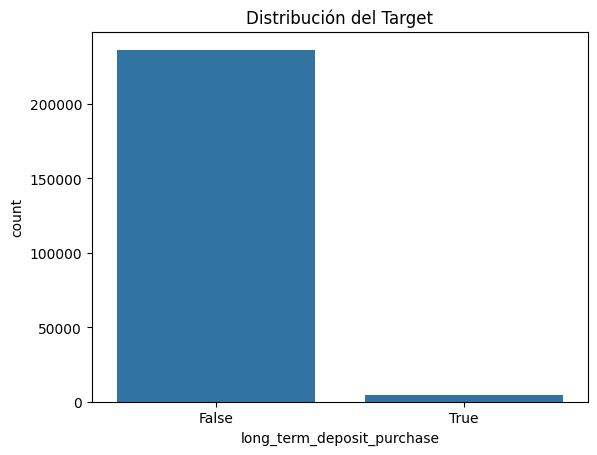

In [39]:
sns.countplot(x=df_final[TARGET_PRODUCT_LTD])
plt.title('Distribución del Target')
plt.show()

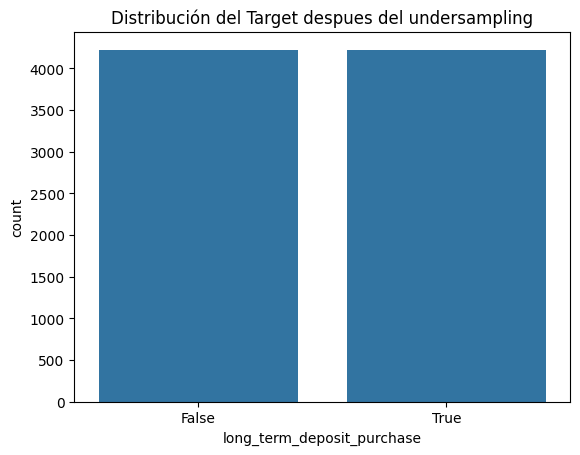

In [40]:
# Está bastante desbalanceado (solo el 1.75% son compradores) por lo que aplicaremos undersampling

undersampler = RandomUnderSampler(random_state=121)
X_resampled, y_resampled = undersampler.fit_resample(X_long_term_deposit, y_long_term_deposit)

sns.countplot(x=y_resampled)
plt.title('Distribución del Target despues del undersampling')
plt.show()

In [41]:
X_train_long_term_deposit, X_test_long_term_deposit, y_train_long_term_deposit, y_test_long_term_deposit = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)

print(f'X_train: {X_train_long_term_deposit.shape}')
print(f'y_train: {y_train_long_term_deposit.shape}')
print(f'X_test: {X_test_long_term_deposit.shape}')
print(f'y_test: {y_test_long_term_deposit.shape}')

X_train: (6763, 36)
y_train: (6763,)
X_test: (1691, 36)
y_test: (1691,)


In [42]:
# # from sklearn.model_selection import GridSearchCV

# # # Define the parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=XGBClassifier(random_state=123),
#                            param_grid=param_grid,
#                            scoring='roc_auc',  # Use AUC-ROC for evaluation
#                            cv=3,  # 3-fold cross-validation
#                            verbose=2,
#                            n_jobs=-1) # Use all available cores

# # Fit the grid search to the data
# grid_search.fit(X_train_long_term_deposit, y_train_long_term_deposit)

# # Print the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best AUC-ROC score found: ", grid_search.best_score_)

# # Get the best model
# best_model_long_term_deposit = grid_search.best_estimator_

In [43]:
# Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
# Creamos un Gradient Boosting
model_long_term_deposit = XGBClassifier(
    n_estimators=300,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    random_state=123
)
model_long_term_deposit.fit(X_train_long_term_deposit, y_train_long_term_deposit)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [44]:
# Guardamos el modelo para poder usarlo desde otro notebook

joblib.dump(model_long_term_deposit, path.join(base_path, 'models/model_long_term_deposit.pkl'))

['/content/drive/MyDrive/data/TFM/models/model_long_term_deposit.pkl']

## 6. Evaluación de los modelos

### 6.1. Modelo PENSION_PLAN_PURCHASE

In [45]:
# Predicciones
y_train_pred = model_pension_plan.predict(X_train_pension_plan)
y_test_pred = model_pension_plan.predict(X_test_pension_plan)

y_train_pred_proba = model_pension_plan.predict_proba(X_train_pension_plan)[:, 1]
y_test_pred_proba = model_pension_plan.predict_proba(X_test_pension_plan)[:, 1]

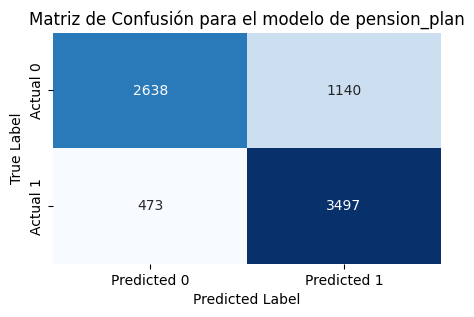

In [46]:
# Matriz de confusión modelo 1
confusion_pension_plan = confusion_matrix(y_test_pension_plan, y_test_pred)

plt.figure(figsize=(5, 3))
plt.title('Matriz de Confusión para el modelo de pension_plan')
sns.heatmap(confusion_pension_plan, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

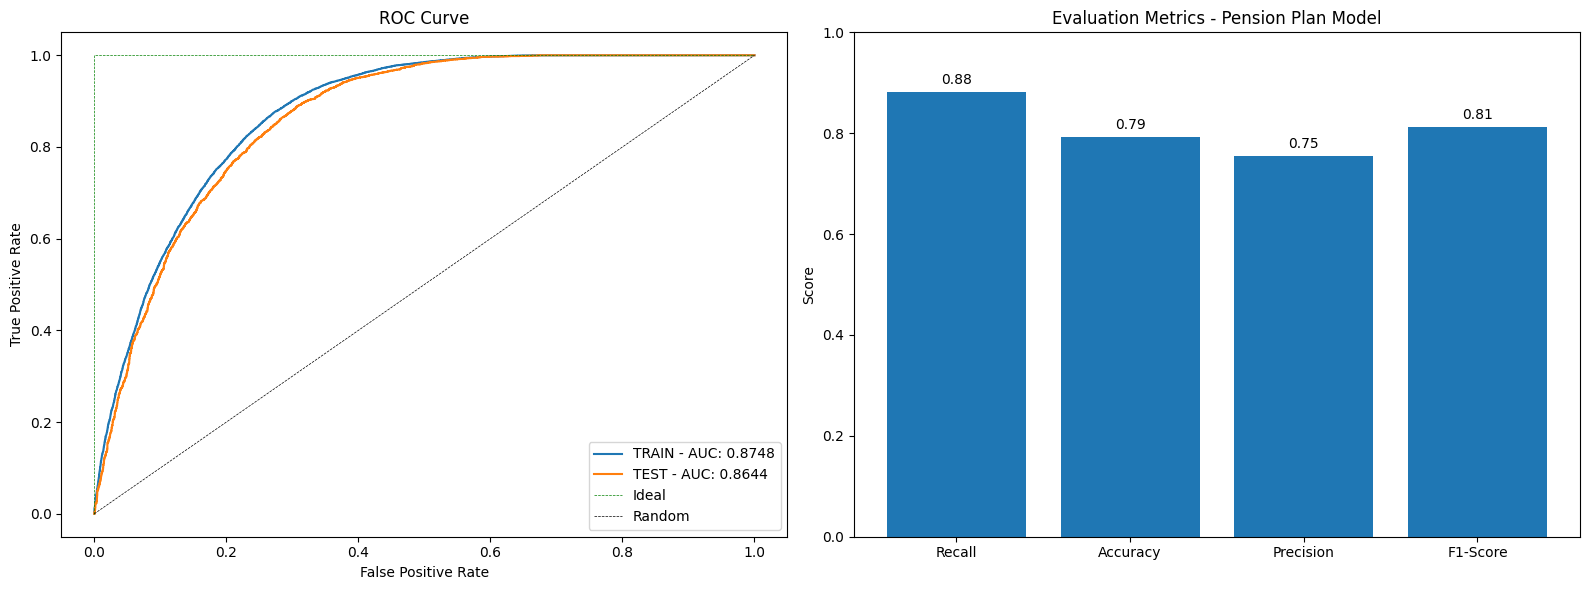

Recall del modelo de pension_plan: 88.09%
Accuracy del modelo de pension_plan: 79.18%
Precision del modelo de pension_plan: 75.42%
F1-Score del modelo de pension_plan: 81.26%


In [47]:
# Accuracy: De todas las predicciones, cuales son realmente correctas?
accuracy_pension_plan = model_pension_plan.score(X_test_pension_plan, y_test_pension_plan)

# Recall: tasa de verdaderos positivos: De todos los 'true', cuantos identificamos como true realmente?
recall_pension_plan = confusion_pension_plan[1, 1] / (confusion_pension_plan[1, 0] + confusion_pension_plan[1, 1])

# Precision: valor predictivo positivo: De todas las predicciones de compra (True) ¿Cuantas fueron correctas?
precision_pension_plan = confusion_pension_plan[1, 1] / (confusion_pension_plan[0, 1] + confusion_pension_plan[1, 1])

# F1-Score: media entre precision y recall
f1_pension_plan = 2 * (precision_pension_plan * recall_pension_plan) / (precision_pension_plan + recall_pension_plan)

# AUC-ROC: cuantifica qué tan bien un modelo de clasificacion puede distinguir entre 2 clases
auc_train = roc_auc_score(y_train_pension_plan, y_train_pred_proba)
auc_test = roc_auc_score(y_test_pension_plan, y_test_pred_proba)

# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train_pension_plan, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_pension_plan, y_test_pred_proba)


# ------------------------- MOSTRAR RESULTADOS: -------------------------------- #

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
axes[0].plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
axes[0].set_title('ROC Curve')
axes[0].plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

metrics = ['Recall', 'Accuracy', 'Precision', 'F1-Score']
scores = [recall_pension_plan, accuracy_pension_plan, precision_pension_plan, f1_pension_plan]

bars = axes[1].bar(metrics, scores)
axes[1].set_title('Evaluation Metrics - Pension Plan Model')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

# Añadir los valores en las barras
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')


plt.tight_layout()
plt.show()

print(f'Recall del modelo de pension_plan: {round(recall_pension_plan * 100, 2)}%')
print(f'Accuracy del modelo de pension_plan: {round(accuracy_pension_plan * 100, 2)}%')
print(f'Precision del modelo de pension_plan: {round(precision_pension_plan * 100, 2)}%')
print(f'F1-Score del modelo de pension_plan: {round(f1_pension_plan * 100, 2)}%')

### 6.2. Modelo SHORT_TERM_DEPOSIT_PURCHASE

In [48]:
# Predicciones
y_train_pred = model_short_term_deposit.predict(X_train_short_term_deposit)
y_test_pred = model_short_term_deposit.predict(X_test_short_term_deposit)

y_train_pred_proba = model_short_term_deposit.predict_proba(X_train_short_term_deposit)[:, 1]
y_test_pred_proba = model_short_term_deposit.predict_proba(X_test_short_term_deposit)[:, 1]

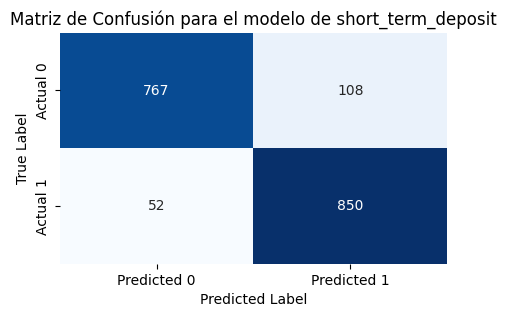

In [49]:
# Matriz de confusión modelo 2
confusion_short_term_deposit = confusion_matrix(y_test_short_term_deposit, y_test_pred)

plt.figure(figsize=(5, 3))
plt.title('Matriz de Confusión para el modelo de short_term_deposit')
sns.heatmap(confusion_short_term_deposit, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

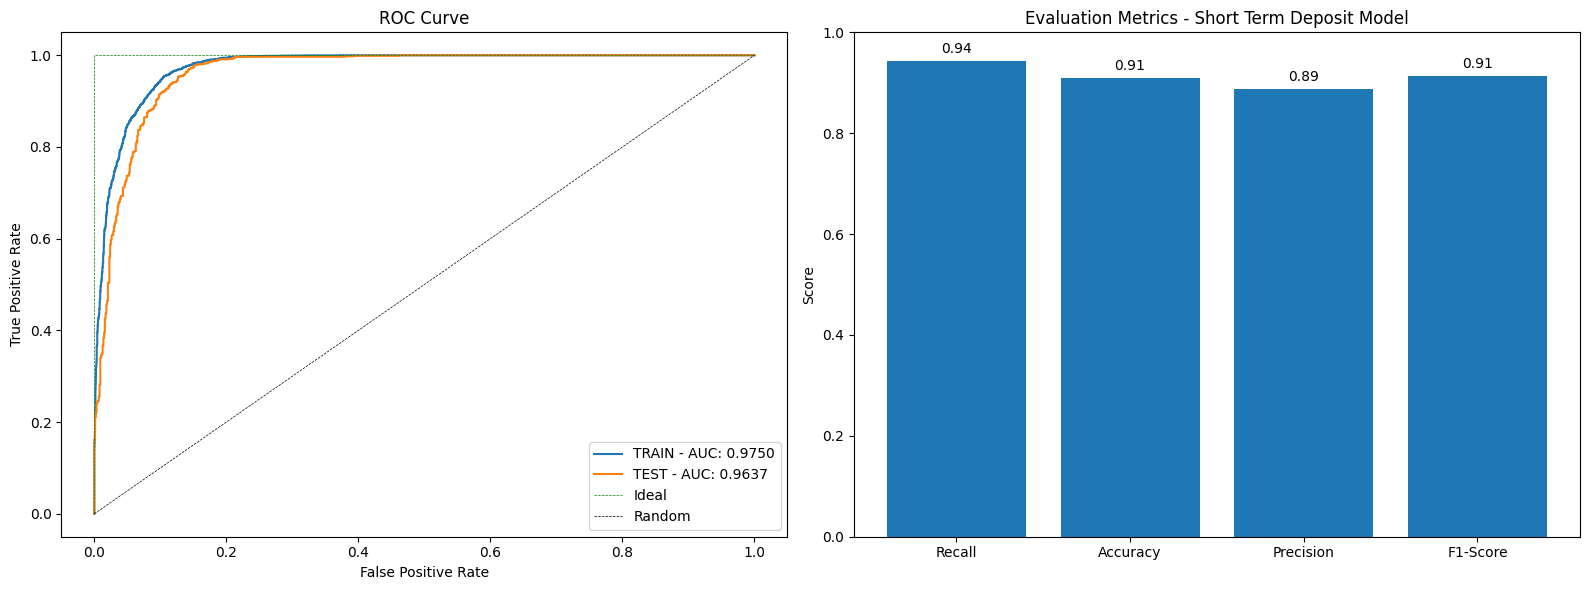

Recall del modelo de short_term_deposit: 94.24%
Accuracy del modelo de short_term_deposit: 91.0%
Precision del modelo de short_term_deposit: 88.73%
F1-Score del modelo de short_term_deposit: 91.4%


In [50]:
# Accuracy: De todas las predicciones, cuales son realmente correctas?
accuracy_short_term_deposit = model_short_term_deposit.score(X_test_short_term_deposit, y_test_short_term_deposit)

# Recall: tasa de verdaderos positivos: De todos los 'true', cuantos identificamos como true realmente?
recall_short_term_deposit = confusion_short_term_deposit[1, 1] / (confusion_short_term_deposit[1, 0] + confusion_short_term_deposit[1, 1])

# Precision: valor predictivo positivo: De todas las predicciones de compra (True) ¿Cuantas fueron correctas?
precision_short_term_deposit = confusion_short_term_deposit[1, 1] / (confusion_short_term_deposit[0, 1] + confusion_short_term_deposit[1, 1])

# F1-Score: media entre precision y recall
f1_short_term_deposit = 2 * (precision_short_term_deposit * recall_short_term_deposit) / (precision_short_term_deposit + recall_short_term_deposit)

# AUC-ROC: cuantifica qué tan bien un modelo de clasificacion puede distinguir entre 2 clases
auc_train = roc_auc_score(y_train_short_term_deposit, y_train_pred_proba)
auc_test = roc_auc_score(y_test_short_term_deposit, y_test_pred_proba)

# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train_short_term_deposit, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_short_term_deposit, y_test_pred_proba)


# ------------------------- MOSTRAR RESULTADOS: -------------------------------- #

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
axes[0].plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
axes[0].set_title('ROC Curve')
axes[0].plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

metrics = ['Recall', 'Accuracy', 'Precision', 'F1-Score']
scores = [recall_short_term_deposit, accuracy_short_term_deposit, precision_short_term_deposit, f1_short_term_deposit]

bars = axes[1].bar(metrics, scores)
axes[1].set_title('Evaluation Metrics - Short Term Deposit Model')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

# Añadir los valores en las barras
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')


plt.tight_layout()
plt.show()

print(f'Recall del modelo de short_term_deposit: {round(recall_short_term_deposit * 100, 2)}%')
print(f'Accuracy del modelo de short_term_deposit: {round(accuracy_short_term_deposit * 100, 2)}%')
print(f'Precision del modelo de short_term_deposit: {round(precision_short_term_deposit * 100, 2)}%')
print(f'F1-Score del modelo de short_term_deposit: {round(f1_short_term_deposit * 100, 2)}%')

### 6.3. Modelo LONG_TERM_DEPOSIT_PURCHASE

In [51]:
# Predicciones
y_train_pred = model_long_term_deposit.predict(X_train_long_term_deposit)
y_test_pred = model_long_term_deposit.predict(X_test_long_term_deposit)

y_train_pred_proba = model_long_term_deposit.predict_proba(X_train_long_term_deposit)[:, 1]
y_test_pred_proba = model_long_term_deposit.predict_proba(X_test_long_term_deposit)[:, 1]

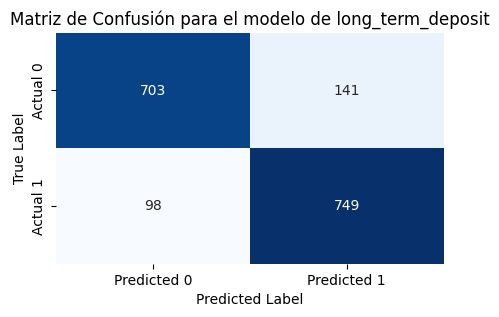

In [52]:
# Matriz de confusión modelo 3
confusion_long_term_deposit = confusion_matrix(y_test_long_term_deposit, y_test_pred)

plt.figure(figsize=(5, 3))
plt.title('Matriz de Confusión para el modelo de long_term_deposit')
sns.heatmap(confusion_long_term_deposit, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

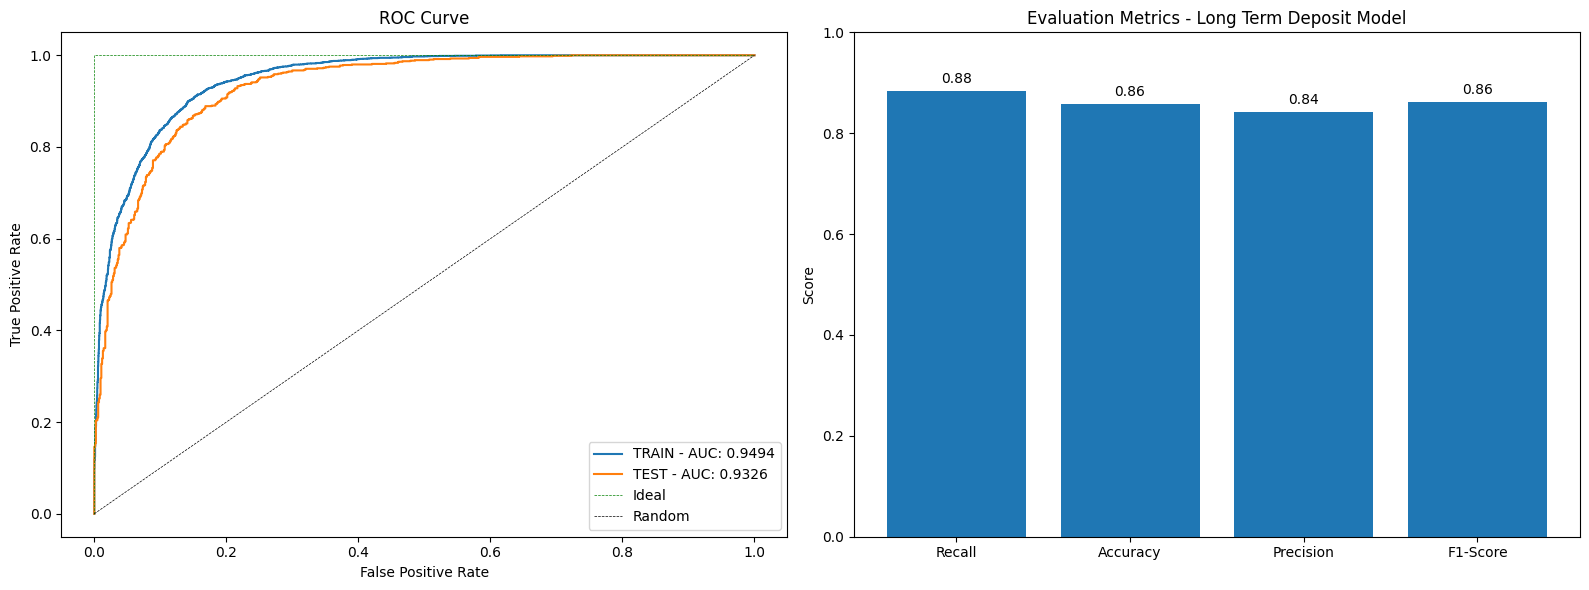

Recall del modelo de long_term_deposit: 88.43%
Accuracy del modelo de long_term_deposit: 85.87%
Precision del modelo de long_term_deposit: 84.16%
F1-Score del modelo de long_term_deposit: 86.24%


In [53]:
# Accuracy: De todas las predicciones, cuales son realmente correctas?
accuracy_long_term_deposit = model_long_term_deposit.score(X_test_long_term_deposit, y_test_long_term_deposit)

# Recall: tasa de verdaderos positivos: De todos los 'true', cuantos identificamos como true realmente?
recall_long_term_deposit = confusion_long_term_deposit[1, 1] / (confusion_long_term_deposit[1, 0] + confusion_long_term_deposit[1, 1])

# Precision: valor predictivo positivo: De todas las predicciones de compra (True) ¿Cuantas fueron correctas?
precision_long_term_deposit = confusion_long_term_deposit[1, 1] / (confusion_long_term_deposit[0, 1] + confusion_long_term_deposit[1, 1])

# F1-Score: media entre precision y recall
f1_long_term_deposit = 2 * (precision_long_term_deposit * recall_long_term_deposit) / (precision_long_term_deposit + recall_long_term_deposit)

# AUC-ROC: cuantifica qué tan bien un modelo de clasificacion puede distinguir entre 2 clases
auc_train = roc_auc_score(y_train_long_term_deposit, y_train_pred_proba)
auc_test = roc_auc_score(y_test_long_term_deposit, y_test_pred_proba)

# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train_long_term_deposit, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_long_term_deposit, y_test_pred_proba)

# ------------------------- MOSTRAR RESULTADOS: -------------------------------- #

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
axes[0].plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
axes[0].set_title('ROC Curve')
axes[0].plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

metrics = ['Recall', 'Accuracy', 'Precision', 'F1-Score']
scores = [recall_long_term_deposit, accuracy_long_term_deposit, precision_long_term_deposit, f1_long_term_deposit]

bars = axes[1].bar(metrics, scores)
axes[1].set_title('Evaluation Metrics - Long Term Deposit Model')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

# Añadir los valores en las barras
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')


plt.tight_layout()
plt.show()

print(f'Recall del modelo de long_term_deposit: {round(recall_long_term_deposit * 100, 2)}%')
print(f'Accuracy del modelo de long_term_deposit: {round(accuracy_long_term_deposit * 100, 2)}%')
print(f'Precision del modelo de long_term_deposit: {round(precision_long_term_deposit * 100, 2)}%')
print(f'F1-Score del modelo de long_term_deposit: {round(f1_long_term_deposit * 100, 2)}%')

## 7. Feature importances

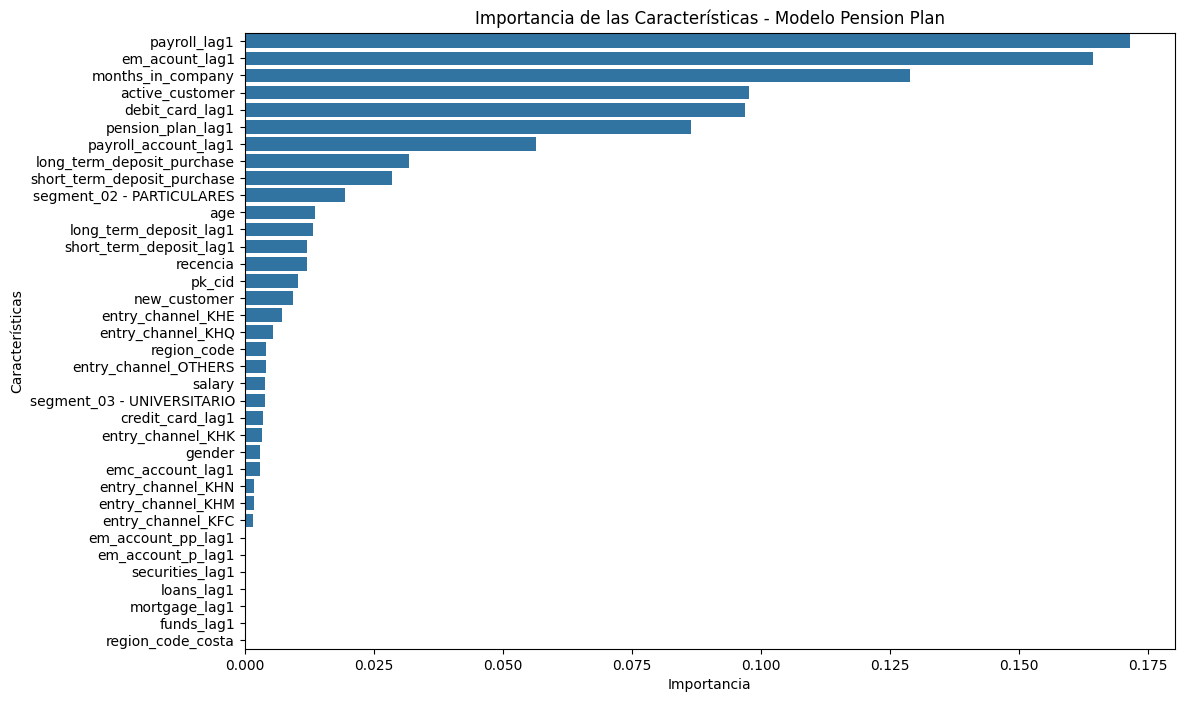

In [54]:
# Obtener la importancia de las características
feature_importances = model_pension_plan.feature_importances_

# Crear un DataFrame con las importancias y los nombres de las características
features_df = pd.DataFrame({
    'Feature': X_train_pension_plan.columns,
    'Importance': feature_importances
})

# Ordenar por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las Características - Modelo Pension Plan')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

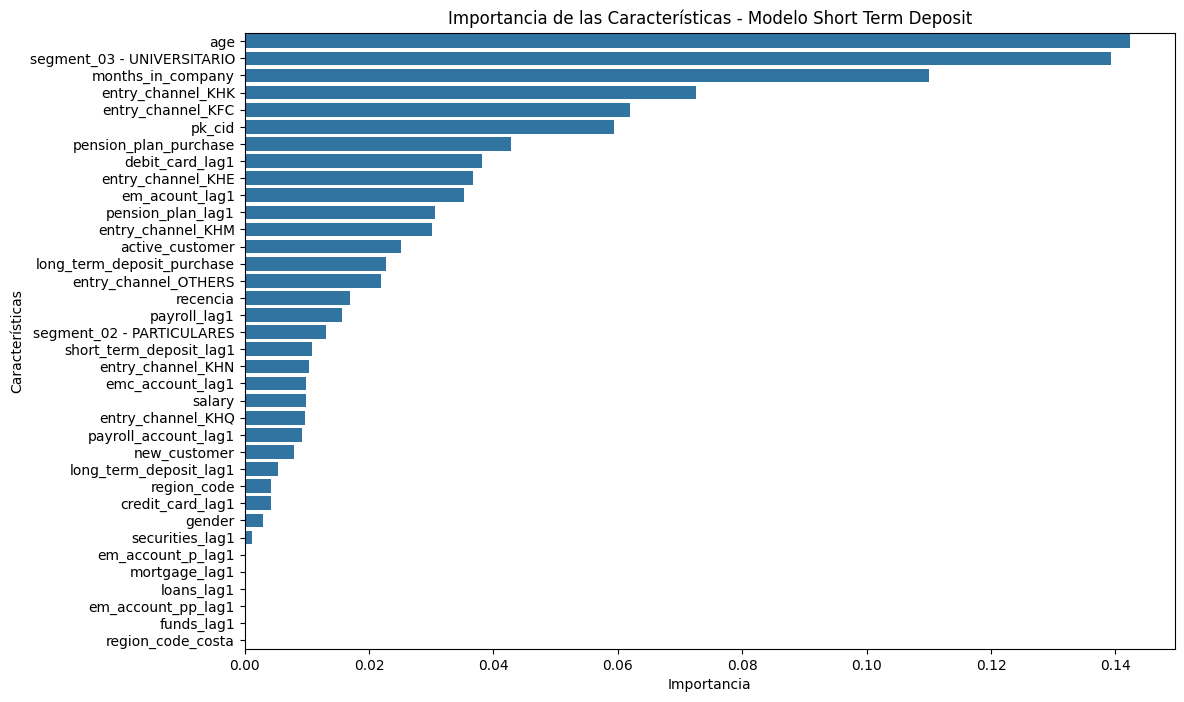

In [55]:
# Obtener la importancia de las características
feature_importances = model_short_term_deposit.feature_importances_

# Crear un DataFrame con las importancias y los nombres de las características
features_df = pd.DataFrame({
    'Feature': X_train_short_term_deposit.columns,
    'Importance': feature_importances
})

# Ordenar por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las Características - Modelo Short Term Deposit')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

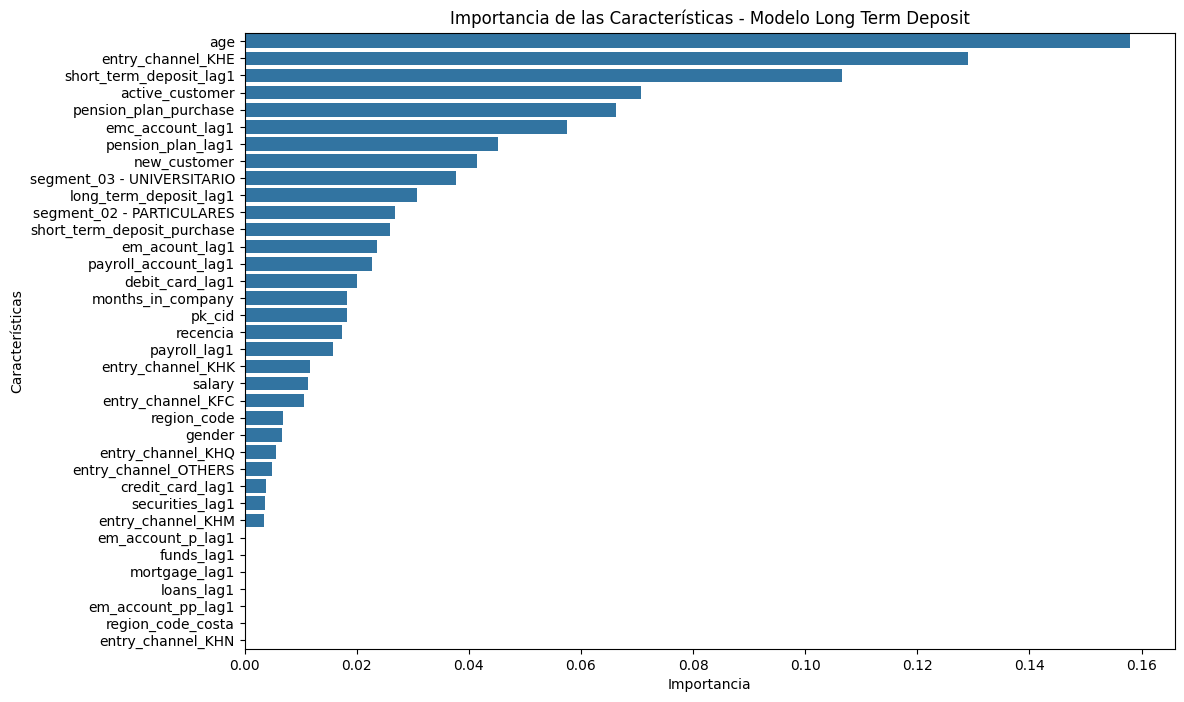

In [56]:
# Obtener la importancia de las características
feature_importances = model_long_term_deposit.feature_importances_

# Crear un DataFrame con las importancias y los nombres de las características
features_df = pd.DataFrame({
    'Feature': X_train_long_term_deposit.columns,
    'Importance': feature_importances
})

# Ordenar por importancia
features_df = features_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Importancia de las Características - Modelo Long Term Deposit')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## 8. Interpretación y resumen de los resultados

Finalmente hemos optado por construir tres modelos predictivos Gradient Boosting(XGBoost) ya que aporta máxima precisión y rendimiento en la predicción de clasificaciones, para identificar a los clientes con mayor propensión a comprar los productos clave que generan mayor rentabilidad a la compañía: Plan de Pensiones, Depósito a Corto Plazo y Depósito a Largo Plazo.

En los 3 casos, la variable target estaba muy desbalanceada por lo que se ha usado la funcion RandomUnderSampler para solucionar el desbalance de clases.
Al principio nuestro modelo sufría de Data Lakeage con los items de cada cliente como el payroll, pension_plan... con lo que usamos el método shift para asegurar que las tenencias de estos productos se basan en información anterior a la compra objetivo


#### 8.1. Interpretación del modelo de Plan de Pensiones

Capacidad Predictiva (AUC-ROC Test): 0.8644 (Sólido)

Eficiencia (Precision): 0.75

Detección (Recall): 0.88

Top 3 variables predictoras (de más a menos importante):

*   **payroll_lag1**: CRUCIAL. La tenencia de la nómina domiciliada el mes anterior es el predictor más fuerte.
*   **em_acount_lag1**: Tenencia de la cuenta principal en el mes anterior.
*   **months_in_company**: La antigüedad es fundamental, sugiriendo un cliente más leal y establecido.

**Propuesta de Estrategia de Marketing**: Este es un producto de vinculación profunda. Las campañas deben enfocarse exclusivamente en clientes que ya tienen su nómina domiciliada y tienen una antigüedad considerable. El marketing debe ser de valor agregado y fidelización, no de captación masiva.

#### 8.2. Interpretación del modelo de Depósito a Corto Plazo

Capacidad Predictiva (AUC-ROC Test): 0.9637 (Excepcional)

Eficiencia (Precision): 0.89

Detección (Recall): 0.94

Top 3 variables predictoras (de más a menos importante):

*   **age**: El factor más importante es el demográfico. La propensión disminuye con la edad.
*   **segment_03_UNIVERSITARIO**: Fuerte propensión en el segmento más joven.
*   **months_in_company**: 	La antigüedad del cliente es relevante, lo que sugiere fidelización temprana.

**Propuesta de Estrategia de Marketing**:  Campañas de marketing enfocadas en el perfil demográfico joven (universitario) y clientes con baja antigüedad, ofreciendo opciones de ahorro sencillas y flexibles.

#### 8.3. Interpretación del modelo de Depósito a Largo Plazo

Capacidad Predictiva (AUC-ROC Test): 0.9326 (Excelente)

Eficiencia (Precision): 0.84

Detección (Recall): 0.88

Top 3 variables predictoras (de más a menos importante):

*   **age**: La propensión aumenta con la edad (perfil de acumulación).
*   **entry_channel_KHE**: Importancia de reactivar a clientes captados por este canal específico.
*   **short_term_deposit_lag1**: Clientes que tenían el depósito a corto plazo en el mes anterior.

**Propuesta de Estrategia de Marketing**: Campañas de Cross-Selling y Up-Selling dirigidas a clientes de mayor edad que ya poseen el producto de corto plazo (short_term_deposit_lag1). Se deben promocionar los beneficios de la reinversión y la estabilidad a largo plazo.